In [9]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import seaborn as sns
sns.set()
sns.set_context("paper")

plt.rc('text', usetex=True)
plt.rc('font', family='serif')

In [10]:
with open('./files/time_vs_error/e_500_250_50.pkl', 'rb') as f:
    nn_errors_list = pickle.load(f)
    
with open('./files/time_vs_error/t_500_250_50.pkl', 'rb') as f:
    nn_times_list = pickle.load(f)
    
with open('./files/time_vs_error/e.pkl', 'rb') as f:
    lw_errors_list = pickle.load(f)
    
with open('./files/time_vs_error/t.pkl', 'rb') as f:
    lw_times_list = pickle.load(f)


In [11]:
class ErrorNotInRange(Exception):
    pass

In [12]:
from scipy import interpolate

def is_between(x1, x2, y):
    """
    checks if y is between x1 and x2
    """
    
    if (y > x1 and y < x2) or (y>x2 and y<x1):
        return True
    else:
        return False

def get_error_times(errors_list, cum_time_list, error):
    
    for i in range(len(errors_list)):
        
        if i != len(errors_list) and i%99!=0 and i!=0:
            first = errors_list[i]
            second = errors_list[i+1]
            
            if is_between(first, second, error):
                return (first, second, cum_time_list[i], cum_time_list[i+1])

    raise ErrorNotInRange("error is not in the range")
            
def interpolate_error_times(error1, error2, time1, time2, error):
    
    # let t be y, errors be x
    
#     x = [error1, error2]
#     y = [time1, time2]
#     f = interpolate.interp1d(x, y)
#     time_interpolated_scipy = f(error)

    gradient = (time2 - time1) / (error2 - error1)
    y_intercept = time1 - gradient*error1
    time_interpolated = gradient*error + y_intercept

    return time_interpolated

In [13]:
from tqdm import tqdm

num = 100

error_range = np.logspace(0, -11, num=num)
total_times_nn = []
total_times_lw = []

for i in tqdm(range(len(nn_errors_list))):
    
    nn_error_list_curr = nn_errors_list[i]
    nn_time_list_curr = np.cumsum(nn_times_list[i])
    lw_error_list_curr = lw_errors_list[i]
    lw_time_list_curr = np.cumsum(lw_times_list[i])
    extrap_time_nn = []
    extrap_time_lw = []
    
    for error in error_range:
        
        try:
            e1, e2, t1, t2 = get_error_times(nn_error_list_curr,nn_time_list_curr, error)
            time_interpolated = interpolate_error_times(e1, e2, t1, t2, error)
            extrap_time_nn.append(time_interpolated)
            
        except:
            continue
        
        
    for error in error_range:
        
        try:
            e1, e2, t1, t2 = get_error_times(lw_error_list_curr,lw_time_list_curr, error)
            time_interpolated = interpolate_error_times(e1, e2, t1, t2, error)
            extrap_time_lw.append(time_interpolated)
            
        except:
            continue
    
    total_times_nn.append(extrap_time_nn)
    total_times_lw.append(extrap_time_lw)

100%|██████████| 1000/1000 [02:00<00:00,  8.29it/s]


In [14]:
tot = 500
nn_accepted = []
lw_accepted = []

for i in total_times_nn:
    if len(i) == num:
        nn_accepted.append(i)
    if len(nn_accepted) == tot:
        break
        
for i in total_times_lw:
    if len(i) == num:
        lw_accepted.append(i)
    if len(lw_accepted) == tot:
        break

In [15]:
def confidence_interval(data, interval=0.60):
    """
    data.shape: [N x ...]
    """
    n_data = len(data)
    data = np.sort(data, axis=0)
    
    outside_interval = (1-interval)/2
    index = outside_interval * n_data
    assert abs(round(index)-index) < 1e-3
    index = round(index)
    
    lower = data[index-1, ...]
    upper = data[n_data-index, ...]
    
    return lower, upper

In [16]:
nn_lower, nn_upper = confidence_interval(nn_accepted, interval=0.6)
lw_lower, lw_upper = confidence_interval(lw_accepted, interval=0.6)

In [17]:
nn_accepted_mean = np.mean(nn_accepted, axis=0)
lw_accepted_mean = np.mean(lw_accepted, axis=0)

nn_accepted_median = np.median(nn_accepted, axis=0)
lw_accepted_median = np.median(lw_accepted, axis=0)

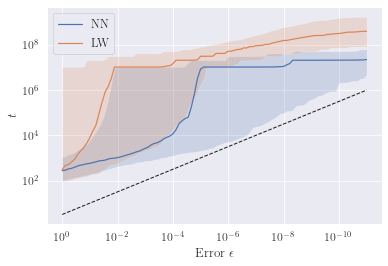

In [20]:
f = plt.figure()
t_limit = np.pi * 1/np.sqrt(error_range)
plt.plot(error_range, t_limit, color='k', linestyle='--', linewidth=1)
plt.plot(error_range, nn_accepted_median, label='NN')
plt.plot(error_range, lw_accepted_median, label='LW')
plt.fill_between(error_range, nn_lower, nn_upper, alpha=0.2)
plt.fill_between(error_range, lw_lower, lw_upper, alpha=0.2)
plt.xscale('log')
plt.yscale('log')
plt.ylabel('$t$', fontsize=13)
plt.xlabel('Error $\epsilon$', fontsize=13)
plt.legend(fontsize=12)
ax=plt.gca()
ax.invert_xaxis()
# plt.title("MEDIAN")
plt.setp(ax.get_xticklabels(), fontsize=12)
plt.setp(ax.get_yticklabels(), fontsize=12)
plt.show()
f.savefig("./figures/time_vs_error_median.pdf",dpi=300)